In [20]:
using LinearAlgebra
using BenchmarkTools
using LaTeXStrings
using QuantumOptics
using Plots

As a general scenario, we consider a Lindblad master equation denoted by,
$$ 
\mathcal{L}\rho =\frac{d \rho}{dt} = -i[H, \rho] + \sum_{k=1}^r L_k \rho L_k^\dagger -\frac{1}{2}\left\{L^\dagger_k L_k, \rho \right\}.
$$
From the above equation we introduce $p\leq r$ counting fields with weights $\nu_k$. This defines the generalized master equation (GME),
$$
\mathcal{L}_\chi \rho_\chi = \left(\mathcal{L} + \Delta \mathcal{L}_\chi \right)\rho_\chi,
$$
where,
$$
 \Delta \mathcal{L}_\chi = \sum_{k=1}^p(1-e^{i\nu_k \chi}) L_k \rho L_k^\dagger .
$$
Whatever method we use to compute the FCS, we start by vectorizating the GME,
$$
\mathcal{L}_\chi\rho_\chi \to   \mathcal{L}_\chi|\rho_\chi \rangle \rangle 
$$

Upon vectorization, the current fluctuations can be computed through

$$
\langle \langle I^n \rangle \rangle = \sum_{m=1}^n \binom{n}{m} \langle \langle 1| \mathcal{L}^{(m)}| \rho^{(n-m)}\rangle \rangle,
$$
where,
$$
| \rho^n\rangle \rangle = \mathcal{L}^+\sum_{m=1}^n \binom{n}{m}\left(  \langle \langle I^m \rangle \rangle - \mathcal{L}^{(m)}\right)|\rho^{(n-m)} \rangle \rangle
$$
and $|\rho^0\rangle \rangle := | \rho_{\rm ss}\rangle \rangle$.

In Julia vectors start at index 1. Therefore, it is more convenient to work with $| \sigma^{n+1} \rangle \rangle = | \rho^n\rangle \rangle$, which entail $| \sigma^{1} \rangle \rangle = | \rho^0\rangle \rangle$. We thus rewrite the above recursive formulas in terms of it


$$
\boxed{
\langle \langle I^n \rangle \rangle = \sum_{m=1}^n \binom{n}{m} \langle \langle 1| \mathcal{L}^{(m)}| \sigma^{(n+1-m)}\rangle \rangle,
}
$$
$$
\boxed{
| \sigma^n\rangle \rangle = \mathcal{L}^+\sum_{m=1}^{n-1} \binom{n-1}{m}\left( \langle \langle I^m \rangle \rangle - \mathcal{L}^{(m)}\right)|\sigma^{(n-m)} \rangle \rangle
}
$$


In [4]:
function cumulants_recursive(H::AbstractOperator, J, mJ, nC::Int64, rho_ss ; nu = vcat(fill(-1, Int(length(J)/2)),fill(1, Int(length(J)/2))))
    l = length(rho_ss)
    IdL = Matrix{ComplexF64}(I, l, l)
    OdL = 1im*zeros(l,l)
    vId = vec(Matrix{ComplexF64}(I, size(rho_ss.data)))'
    # Ln = [if k==1; OdL; else;  m_jumps(mJ; n = k, nu = nu); end for k=1:nC+1]
    Ln = [m_jumps(mJ; n = k, nu = nu) for k=1:nC]
    vrho0 = vec(rho_ss.data)
    vI = 0.0*Vector{Float64}(undef, nC)
    vI[1] = real(vId* Ln[1]*vrho0)
    if nC > 1
        vrho = [Vector{ComplexF64}(undef, l) for j=1:nC]
        vrho[1] = vrho0
        LD = drazin(H, J, rho_ss)
        for n = 2:nC
            vrho[n] = LD*sum(binomial(n-1, m)*(vI[m]*IdL*vrho[n-m] - Ln[m]*vrho[n-m]) for m=1:n-1)
            vI[n] = real(vId*sum(binomial(n, m)*Ln[m]*vrho[n+1-m] for m=1:n))
        end
    end
    return vI
end


function drazin(H::AbstractOperator, J, rho_ss)
    d = length(H)
    vId = reshape(Matrix(identityoperator(H).data), d)'
    vss = reshape(Matrix(rho_ss.data), d)
    L = liouvillian(H, J)
    vL = Matrix(L.data)
    IdL = Matrix{ComplexF64}(I, d, d)
    Q = IdL - vss*vId
    LD = Q*pinv(vL)*Q
    return LD
end

function m_jumps(mJ; n=1, nu = vcat(fill(-1, Int(length(J)/2)),fill(1, Int(length(J)/2))))
    return sum(nu[k]^n*kron(conj(mJ[k].data), mJ[k].data) for k = 1:length(mJ))
end



m_jumps (generic function with 1 method)

# Test for the Drazin inverse

From melt.nb documentation, we have that a master equation of the form
$$ \mathcal{L} \rho = -i[\sigma_z,\rho]   + \gamma_m D[\sigma\rho + \gamma_p D[\sigma^\dagger]\rho.$$

The above Liouvillian has a corresponding Drazin inverse of the form,
$$\mathcal{L}^+ = \begin{pmatrix}
-\frac{\gamma_m}{(\gamma_m + \gamma_p)^2} & 0 & 0 & \frac{\gamma_p}{(\gamma_m + \gamma_p)^2}\\
0 & - \frac{2}{-4i + \gamma_m + \gamma_p} & 0 & 0\\
0 & 0 & - \frac{2}{+4i + \gamma_m + \gamma_p} & 0\\
\frac{\gamma_m}{(\gamma_m + \gamma_p)^2} & 0 & 0 & -\frac{\gamma_p}{(\gamma_m + \gamma_p)^2}
    \end{pmatrix}
$$

We now implement this analytical Drazin inverse and use it to test our function to compute the Drazin inverse.

In [73]:
qubit_drazin(γm, γp) = [-γm/(γm+γp)^2 0 0 γp/(γm+γp)^2; 0 -2/(-4im+γm+ γp) 0 0; 0 0 -2/(4im + γm + γp) 0; γm/(γm+ γp)^2 0 0 -γp/(γm + γp)^2]

b_s = SpinBasis(1//2)
σz = sigmaz(b_s)
σm = sigmam(b_s)
σp = sigmap(b_s)
γ = 1.0
γm = 0.5
γp = 0.5
LD_test = qubit_drazin(γm, γp)
J = [√γm*σm, √γp*σp]
L = liouvillian(σz, J)
ρss = steadystate.eigenvector(L)
display(LD_test)
LD = drazin(σz, J, ρss)
display(round.(LD, digits=4))
println("Are these the same?")
isapprox(LD,LD_test, atol=1e-10)

4×4 Matrix{ComplexF64}:
 -0.5+0.0im        0.0+0.0im             0.0+0.0im        0.5+0.0im
  0.0+0.0im  -0.117647-0.470588im        0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im       -0.117647+0.470588im   0.0+0.0im
  0.5+0.0im        0.0+0.0im             0.0+0.0im       -0.5+0.0im

4×4 Matrix{ComplexF64}:
 -0.5-0.0im      0.0+0.0im         0.0+0.0im      0.5-0.0im
  0.0-0.0im  -0.1176-0.4706im      0.0+0.0im      0.0-0.0im
  0.0+0.0im      0.0+0.0im     -0.1176+0.4706im   0.0+0.0im
  0.5+0.0im      0.0+0.0im         0.0+0.0im     -0.5+0.0im

Are these the same?


true

In [54]:
qubit_drazin(γm, γp) - LD

4×4 Matrix{ComplexF64}:
  1.11022e-16+0.0im                  0.0+0.0im  …  -1.11022e-16+0.0im
 -4.15577e-18-1.67536e-17im  5.55112e-17+0.0im     -4.15577e-18-1.67536e-17im
 -8.75728e-18-2.76577e-17im          0.0+0.0im     -8.75728e-18-2.76577e-17im
 -1.11022e-16+0.0im                  0.0+0.0im      1.11022e-16+0.0im

# Two-level system 

In [7]:
b_s = SpinBasis(1//2)
σz = sigmaz(b_s)
σm = sigmam(b_s)
σp = sigmap(b_s)
γ = 1.0
nhf = 0.5
ncf = 0.5
ω = 1.0
H =  ω*σp*σm
J = √γ*[√(1-nhf)*σm, √(1-ncf)*σm, √nhf*σp, √ncf*σp]
# J = [√(γ*(1-nhf))*σm, √(γ*nhf)*σp]
mJ = [J[1], J[3]]
ρss = steadystate.eigenvector(H, J);

vss = vec(ρss.data)
vId = vec(one(b_s).data)'

# Let's make it recursive now!
# We always start by setting up the Drazin inverse, the vectorize jumpps:
Jop = m_jumps(mJ)
LD = drazin(H, J, ρss)
vρ0 = vss
# Then we compute the 1st vector and the 1st cumulant
vρ1 = Jop*vρ0
I1 =real(vId*vρ1)
# Then the 2nd vector and cumulant
I2 = real(vId*(m_jumps(mJ; n=2)*vρ0 - 2*m_jumps(mJ)*LD*vρ1))


println(I1)
println(I2)

-0.5
0.5


In [8]:
K = cumulants_recursive(H, J, mJ, 2, ρss)


4-element Vector{Float64}:
 -0.5
  0.5
 -0.5
  0.5

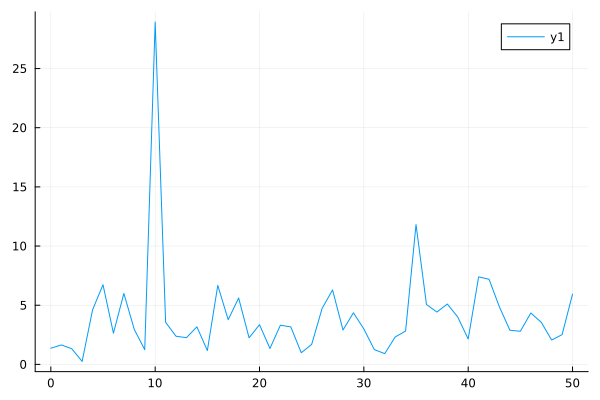

In [23]:
plot(grange, F)

true

In [427]:
real(vId*vρ1)

2.220446049250313e-16

# Bosonic QHE

In [37]:
b_fock = FockBasis(5)
ah = destroy(b_fock)⊗one(b_fock)
ahd = dagger(ah)
ac = one(b_fock)⊗destroy(b_fock)
acd = dagger(ac)

# g = 0.5
κ = 1.0
nbh = 1.0
nbc = 0.1
H =  g*(ahd*ac + acd*ah)
J = [√(κ*(nbh+1))*ah, √(κ*(nbc+1))*ac, √(κ*nbh)*ahd, √(κ*nbc)*acd]
mJ = [J[2], J[4]]
ρss = steadystate.iterative(H, J);

In [2]:
K = cumulants_recursive(H, J, mJ, 2, ρss)
F = K[2]/abs(K[1])

UndefVarError: UndefVarError: `cumulants_recursive` not defined

In [40]:

grange = [0.0:0.1:5.;]
F = zeros(length(grange))
for i=1:length(grange)
    g = grange[i]
    H =  g*(ahd*ac + acd*ah)
    J = [√(κ*(nbh+1))*ah, √(κ*(nbc+1))*ac, √(κ*nbh)*ahd, √(κ*nbc)*acd]
    mJ = [J[2], J[4]]
    ρss = steadystate.iterative(H, J);
    I1, I2 = cumulants_recursive(H, J, J, 2, ρss)
    F[i] = abs(I2/I1)
end

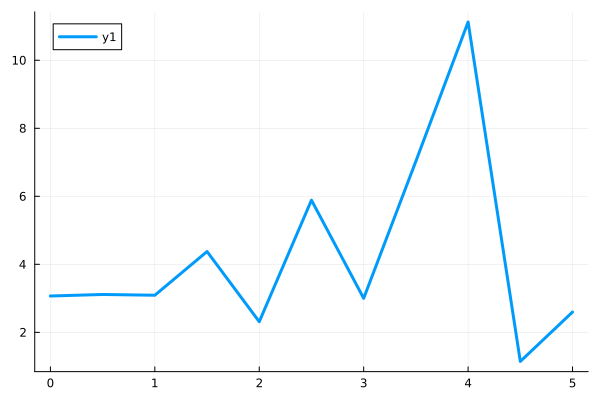

In [39]:
plot(grange, F, lw = 3)